In [2]:
!pip install jovian --upgrade --quiet

## TODO

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training

### Download the Dataset

Using `opendatasets` and download the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [6]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [7]:
od.download(dataset_url)

  1%|          | 5.00M/450M [00:00<00:15, 29.7MB/s]

100%|██████████| 450M/450M [00:08<00:00, 54.4MB/s]


In [8]:
data_dir = './flowers-recognition/flowers'

In [9]:
import os

In [10]:
os.listdir(data_dir)

['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [11]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [12]:
os.listdir(data_dir)

['dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [13]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1055
rose : 784
daisy : 769
sunflower : 734
tulip : 984


In [14]:
!pip install jovian --quiet

In [15]:
import jovian

In [16]:
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/aakashns-6l3/deep-learning-project-live


'https://jovian.ai/aakashns-6l3/deep-learning-project-live'

### Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.



In [17]:
from torchvision.datasets import ImageFolder

In [18]:
dataset = ImageFolder(data_dir)

In [19]:
len(dataset)

4323

In [20]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FD29EDD7198>, 0)

In [21]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

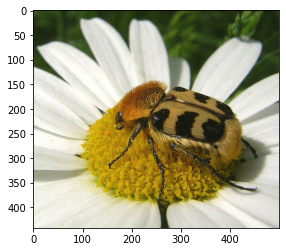

In [23]:
img, label = dataset[120]
plt.imshow(img)

In [24]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

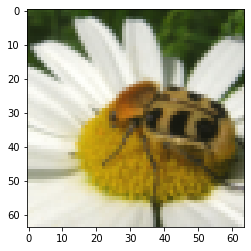

In [25]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [26]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [27]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [28]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

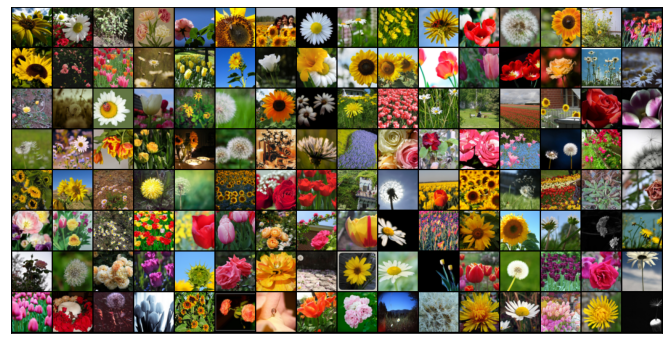

In [30]:
show_batch(train_dl)

### GPU Utilities

In [31]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [32]:
torch.cuda.is_available()

True

In [33]:
device = get_default_device()

In [34]:
device

device(type='cuda')

In [35]:
img, label = dataset[0]

In [36]:
img.device

device(type='cpu')

In [37]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilties

In [51]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [45]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [46]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [43]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [47]:
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/aakashns-6l3/deep-learning-project-live


'https://jovian.ai/aakashns-6l3/deep-learning-project-live'

In [49]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


### Training

In [52]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.1881510466337204, 'val_loss': 1.6121399402618408}]

In [53]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4059, val_loss: 1.3436, val_acc: 0.4388
Epoch [1], train_loss: 0.9347, val_loss: 0.9449, val_acc: 0.6289
Epoch [2], train_loss: 0.8336, val_loss: 0.8913, val_acc: 0.6667
Epoch [3], train_loss: 0.7243, val_loss: 0.8168, val_acc: 0.6855
Epoch [4], train_loss: 0.6556, val_loss: 0.8435, val_acc: 0.6914


In [54]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8391, val_loss: 1.0428, val_acc: 0.6354
Epoch [1], train_loss: 0.6826, val_loss: 0.8951, val_acc: 0.6947
Epoch [2], train_loss: 0.6184, val_loss: 0.6690, val_acc: 0.7513
Epoch [3], train_loss: 0.5407, val_loss: 0.6926, val_acc: 0.7591
Epoch [4], train_loss: 0.4751, val_loss: 0.6711, val_acc: 0.7396


In [59]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3975, val_loss: 0.4808, val_acc: 0.8262
Epoch [1], train_loss: 0.3471, val_loss: 0.4727, val_acc: 0.8151
Epoch [2], train_loss: 0.3318, val_loss: 0.4839, val_acc: 0.8353
Epoch [3], train_loss: 0.3081, val_loss: 0.4861, val_acc: 0.7975
Epoch [4], train_loss: 0.2865, val_loss: 0.4623, val_acc: 0.8223


In [66]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2684, val_loss: 0.4435, val_acc: 0.8242
Epoch [1], train_loss: 0.2748, val_loss: 0.4580, val_acc: 0.8086
Epoch [2], train_loss: 0.2775, val_loss: 0.4440, val_acc: 0.8301
Epoch [3], train_loss: 0.2800, val_loss: 0.4478, val_acc: 0.8242
Epoch [4], train_loss: 0.2699, val_loss: 0.4336, val_acc: 0.8379


In [67]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

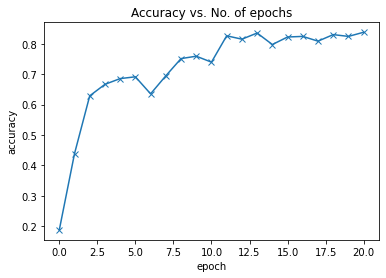

In [68]:
plot_accuracies(history)

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

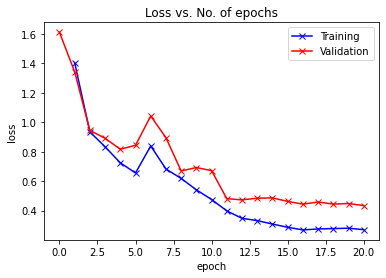

In [70]:
plot_losses(history)

### Record the Results

In [71]:
history[-1]

{'train_loss': 0.26992353796958923,
 'val_acc': 0.837890625,
 'val_loss': 0.433556467294693}

In [73]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       arch='ResNet9', 
                       epochs=[5, 5, 5, 5], 
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [74]:
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aakashns-6l3/deep-learning-project-live


'https://jovian.ai/aakashns-6l3/deep-learning-project-live'

### Test with Individual Images

In [76]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [86]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: sunflower
Prediction: sunflower


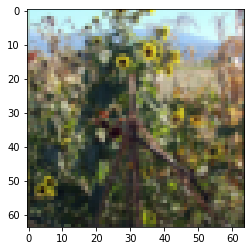

In [87]:
show_image_prediction(*valid_ds[100])

Target: daisy
Prediction: daisy


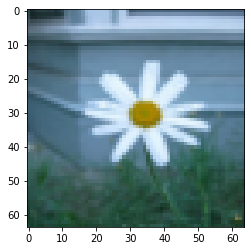

In [88]:
show_image_prediction(*valid_ds[300])

Target: daisy
Prediction: daisy


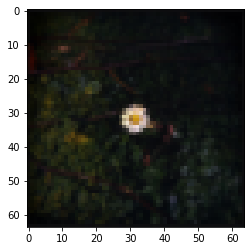

In [89]:
show_image_prediction(*valid_ds[12])

In [90]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [ ]:
jovian